# Construct Glycolysis+ Pathways and Diagrams
__Notes__
- We assume that most of the sugars already exist in the KnowledgeBase as a result of the notebook `Sugar Forms and Variations`, as well as the core nucleotides and deoxynucleotides, via `Nucleotides in the KB`.
- This notebook builds up the reactions of glycolysis, pentose-phophate, entner-doudoroff, and overflow metabolism, as well as the remaining metabolites not covered by the systematic approaches above.
- We use ChEBI as the origin for most metabolite definitions
  - No access or licensing restrictions
  - The precision and granularity we need, e.g. in terms of protonation states, isomeric forms, etc
- Likewise, RHEA is the origin for reaction definitions.
- However, those sources themselves do not serve our overall goals. So we construct and refine canonical KB versions of all the relevant items. The path is
> EC number -> RHEA reaction -> ChEBI compound -> KB compound -> KB reaction
- Start with EC numbers pulled from reference sources.
  - The starting lists are fairly inclusive, so we may be selective about what we include in any final pathways.

In [1]:
import collections
import copy
from ipydatagrid import DataGrid
import ipywidgets as widgets
import json
import pandas as pd
from IPython.display import SVG, display

from mosmo.knowledge import kb
from mosmo.model import DS, DbXref, KbEntry, Molecule, Reaction, Pathway, Specialization, Variation
from mosmo.preso.escher import escher_map, escher_model

# Data files are resources in the `data` package. Pathway diagrams are in `pw`
from importlib.resources import files
import mosmo.preso.escher.pw as pw_files
import data

def datafile(filename):
    return files(data).joinpath(filename)

KB = kb.configure_kb()

## Glycolysis

### Collect RHEA reactions cross-referenced to these EC numbers

In [2]:
glycolysis_rhea = set()
with open(datafile('glycolysis.txt'), 'r') as f:
    for line in f.readlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        ec_ref = DbXref(db=DS.EC, id=line)
        rhea_rxns = KB.xref(KB.RHEA, ec_ref)
        if rhea_rxns:
            glycolysis_rhea.update(rhea_rxns)
        else:
            print(f'{ec_ref} has no corresponding reactions in RHEA')

### Collect associated ChEBI entries, and cross-reference into existing KB molecules
- Where available, navigate up to the canonical form of each KB molecule

In [3]:
chebi_to_kb = {}
for rxn in glycolysis_rhea:
    for chebi_mol in rxn.stoichiometry:
        if chebi_mol not in chebi_to_kb:
            kb_mols = KB.xref(KB.compounds, chebi_mol.ref())
            if len(kb_mols) > 1:
                print(f'{chebi_mol} maps to multiple KB entries.')
            if kb_mols:
                kb_mol = kb_mols[0]
                if kb_mol.canonical_form is not None:
                    kb_mol = KB.get(KB.compounds, kb_mol.canonical_form.parent_id)
            else:
                kb_mol = None
            chebi_to_kb[chebi_mol] = kb_mol

### Manually curate KB compounds
- Assign or edit kbid, name, akas, shorthand, and xrefs
- Generally, any new entry inherits anything it can from the ChEBI entry
- Manually mark KB entries to be updated

In [4]:
class MolEditTask:
    FOCUS_DBS = [DS.KEGG, DS.METACYC, DS.CHEBI, DS.BIGG]
    
    def __init__(self, chebi_mol, kb_mol):
        self.chebi_mols = [chebi_mol]
        self.kb_mol = kb_mol
        self.dirty = False
        self.defunct_kb_id = None

    def data(self):
        data = {
            'chebi_id': ', '.join(chebi_mol.id for chebi_mol in self.chebi_mols),
            'kb_id': self.kb_mol.id if self.kb_mol else '',
        }
        data_mol = self.kb_mol or self.chebi_mols[0]
        data['name'] = data_mol.name
        data['shorthand'] = data_mol.shorthand or ''

        xrefs = {xref.db: xref.id for xref in (data_mol.xrefs or [])}
        for db in MolEditTask.FOCUS_DBS:
            if db in xrefs:
                data[db.id] = xrefs.pop(db)
            else:
                data[db.id] = ''
        if self.kb_mol is None:
            data['CHEBI'] = self.chebi_mols[0].id

        data['others'] = ', '.join(f'{db.id}:{id}' for db, id in sorted(xrefs.items(), key=lambda kv: kv[0].id))

        return data

    def make_kb_entry(self):
        if self.kb_mol is None:
            # New KB molecule is modeled on the first reference molecule, and cross-referenced to it.
            self.kb_mol = copy.deepcopy(self.chebi_mols[0])
            self.kb_mol.id = None  # Must be assigned to save it.
            self.kb_mol.db = None  # Assigned by KB on save
            
            xref = self.chebi_mols[0].ref()
            if self.kb_mol.xrefs:
                self.kb_mol.xrefs.add(xref)
            else:
                self.kb_mol.xrefs = {xref}

            self.dirty = True

    def update_kb_id(self, id):
        if not id:
            return
        if id != self.kb_mol.id:
            if self.kb_mol.id is not None:
                self.defunct_kb_id = self.kb_mol.id
            self.kb_mol.id = id
            self.dirty = True

    def update_name(self, name):
        if not name:
            return
        if name != self.kb_mol.name:
            # Preserve the old name as an aka, and remove the new one if it was an aka.
            if self.kb_mol.aka is not None:
                self.kb_mol.aka.insert(0, self.kb_mol.name)
                try:
                    self.kb_mol.aka.remove(name)
                except ValueError:
                    pass
            else:
                self.kb_mol.aka = [self.kb_mol.name]

            self.kb_mol.name = name
            self.dirty = True
        
    def update_shorthand(self, shorthand):
        shorthand = shorthand or None
        if shorthand != self.kb_mol.shorthand:
            self.kb_mol.shorthand = shorthand
            self.dirty = True

    def update_xref(self, db, id):
        if self.kb_mol.xrefs is None:
            self.kb_mol.xrefs = set()

        existing = None
        for xref in self.kb_mol.xrefs:
            if xref.db == db:
                existing = xref
                break
        if existing is not None and existing.id == id:
            return

        if existing is not None:
            self.kb_mol.xrefs.remove(existing)
            self.dirty = True
        if id:
            self.kb_mol.xrefs.add(DbXref(db=db, id=id))
            self.dirty = True

    def update_other_xrefs(self, xrefs_str):
        xrefs = set()
        if xrefs_str:
            for xref_str in xrefs_str.split(','):
                db, id = xref_str.strip().split(':')
                xrefs.add(DbXref(db=DS.get(db), id=id))
        for xref in xrefs:
            if xref not in self.kb_mol.xrefs:
                self.dirty = True
        for xref in self.kb_mol.xrefs:
            if xref.db in MolEditTask.FOCUS_DBS:
                xrefs.add(xref)
            elif xref not in xrefs:
                self.dirty = True
        self.kb_mol.xrefs = xrefs

In [5]:
class MolEditGrid:
    def __init__(self, tasks):
        self.tasks = sorted(tasks, key=lambda task: (task.kb_mol or task.chebi_mols[0]).name)
        df = pd.DataFrame([task.data() for task in self.tasks]).set_index('chebi_id')
        self.grid = DataGrid(df, editable=True)
        self.grid.on_cell_change(self.on_cell_change)

    def on_cell_change(self, cell):
        # The most robust way to do this is to apply the entire row's data every time
        task = self.tasks[cell['row']]
        row = self.grid.data.iloc[cell['row']]
        
        if task.kb_mol is None:
            task.make_kb_entry()

        task.update_kb_id(row['kb_id'])
        task.update_name(row['name'])
        task.update_shorthand(row['shorthand'])
        for db in task.FOCUS_DBS:
            task.update_xref(db, row[db.id])
        task.update_other_xrefs(row['others'])

    def display(self):
        display(self.grid)

In [6]:
tasks = []
covered = {}
for chebi_mol, kb_mol in chebi_to_kb.items():
    if kb_mol is not None and kb_mol in covered:
        covered[kb_mol].chebi_mols.append(chebi_mol)
    else:
        task = MolEditTask(chebi_mol, kb_mol)
        tasks.append(task)
        if kb_mol is not None:
            covered[kb_mol] = task

mol_edit_grid = MolEditGrid(tasks)
mol_edit_grid.display()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [7]:
for task in mol_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_mol)
        KB.put(KB.compounds, task.kb_mol)
        task.dirty = False

glycolysis_kb_mols = [task.kb_mol for task in mol_edit_grid.tasks if task.kb_mol and task.kb_mol.id]

# Manually add Glc[e], used by PTS (to be added later)
glycolysis_kb_mols.append(KB('Glc.D.ext'))

### Build KB versions of all reactions

In [8]:
class RxnEditTask:
    FOCUS_DBS = [DS.EC, DS.KEGG, DS.METACYC, DS.RHEA, DS.BIGG]
    
    def __init__(self, rhea_rxn, kb_rxn):
        self.rhea_rxn = rhea_rxn
        self.kb_rxn = kb_rxn
        self.dirty = False
        self.defunct_kb_id = None

    def data(self):
        data = {
            'rhea_id': self.rhea_rxn.id,
            'kb_id': self.kb_rxn.id or '',
        }
        data['name'] = self.kb_rxn.name
        data['shorthand'] = self.kb_rxn.shorthand or ''
        data['catalyst'] = self.kb_rxn.catalyst.id if self.kb_rxn.catalyst else ''
        data['rev'] = self.kb_rxn.reversible
        data['equation'] = self.kb_rxn.equation,

        xrefs = {xref.db: xref.id for xref in (self.kb_rxn.xrefs or [])}
        for db in RxnEditTask.FOCUS_DBS:
            if db in xrefs:
                data[db.id] = xrefs.pop(db)
            else:
                data[db.id] = ''

        data['others'] = ', '.join(f'{db.id}:{id}' for db, id in sorted(xrefs.items(), key=lambda kv: kv[0].id))

        return data

    def update_kb_id(self, id):
        if not id:
            return
        if id != self.kb_rxn.id:
            if self.kb_rxn.id is not None:
                self.defunct_kb_id = self.kb_rxn.id
            self.kb_rxn.id = id
            self.dirty = True

    def update_name(self, name):
        if not name:
            return
        if name != self.kb_rxn.name:
            # Preserve the old name as an aka, and remove the new one if it was an aka.
            if self.kb_rxn.aka is not None:
                self.kb_rxn.aka.insert(0, self.kb_rxn.name)
                try:
                    self.kb_rxn.aka.remove(name)
                except ValueError:
                    pass
            else:
                self.kb_rxn.aka = [self.kb_rxn.name]

            self.kb_rxn.name = name
            self.dirty = True
        
    def update_shorthand(self, shorthand):
        shorthand = shorthand or None
        if shorthand != self.kb_rxn.shorthand:
            self.kb_rxn.shorthand = shorthand
            self.dirty = True
        
    def update_catalyst(self, catalyst_id):
        if self.kb_rxn.catalyst:
            if self.kb_rxn.catalyst.id == id:
                return
            else:
                self.kb_rxn.catalyst = None
                self.dirty = True

        if catalyst_id:
            self.kb_rxn.catalyst = Molecule(id=catalyst_id)
            self.dirty = True

    def update_reversible(self, reversible):
        if reversible != self.kb_rxn.reversible:
            self.kb_rxn.reversible = reversible
            self.dirty = True
        
    def update_xref(self, db, id):
        if self.kb_rxn.xrefs is None:
            self.kb_rxn.xrefs = set()

        existing = None
        for xref in self.kb_rxn.xrefs:
            if xref.db == db:
                existing = xref
                break
        if existing is not None and existing.id == id:
            return

        if existing is not None:
            self.kb_rxn.xrefs.remove(existing)
            self.dirty = True
        if id:
            self.kb_rxn.xrefs.add(DbXref(db=db, id=id))
            self.dirty = True

    def update_other_xrefs(self, xrefs_str):
        xrefs = set()
        if xrefs_str:
            for xref_str in xrefs_str.split(','):
                db, id = xref_str.strip().split(':')
                xrefs.add(DbXref(db=DS.get(db), id=id))
        for xref in self.kb_rxn.xrefs:
            if xref.db in RxnEditTask.FOCUS_DBS:
                xrefs.add(xref)

        if xrefs != self.kb_rxn.xrefs:
            self.dirty = True
            self.kb_rxn.xrefs = xrefs

In [9]:
class RxnEditGrid:
    def __init__(self, tasks):
        self.tasks = sorted(tasks, key=lambda task: task.kb_rxn.name)
        df = pd.DataFrame([task.data() for task in self.tasks]).set_index('rhea_id')
        self.grid = DataGrid(df, editable=True)
        self.grid.on_cell_change(self.on_cell_change)

    def on_cell_change(self, cell):
        # The most robust way to do this is to apply the entire row's data every time
        task = self.tasks[cell['row']]
        row = self.grid.data.iloc[cell['row']]
        
        task.update_kb_id(row['kb_id'])
        task.update_name(row['name'])
        task.update_shorthand(row['shorthand'])
        task.update_catalyst(row['catalyst'])
        task.update_reversible(row['rev'])
        for db in task.FOCUS_DBS:
            task.update_xref(db, row[db.id])
        task.update_other_xrefs(row['others'])

    def display(self):
        display(self.grid)

In [10]:
def build_kb_rxn(rhea_rxn):
    # Preemptively build the corresponding KB reaction, but only if we can map all the reactants
    stoichiometry = {}
    for chebi_mol, count in rhea_rxn.stoichiometry.items():
        kb_mols = KB.xref(KB.compounds, chebi_mol.ref())
        if len(kb_mols) == 1:
            kb_mol = kb_mols[0]
            if kb_mol.canonical_form is not None:
                kb_mol = KB.get(KB.compounds, kb_mol.canonical_form.parent_id) 
            stoichiometry[kb_mol] = count
        else:
            # Abort
            return None

    kb_rxn = copy.deepcopy(rhea_rxn)
    kb_rxn.id = None  # Must be assigned to save it.
    kb_rxn.db = None  # Assigned by KB on save
    kb_rxn.stoichiometry = stoichiometry
    if kb_rxn.xrefs is not None:
        kb_rxn.xrefs.add(rhea_rxn.ref())
    else:
        kb_rxn.xrefs = {rhea_rxn.ref()}
    return kb_rxn


tasks = []
skipped_rhea = []
for rhea_rxn in glycolysis_rhea:
    kb_rxns = KB.xref(KB.reactions, rhea_rxn.ref())
    if len(kb_rxns) > 1:
        print(f'{rhea_rxn.ref()} maps to multiple KB entries.')
    if kb_rxns:
        kb_rxn = kb_rxns[0]
    else:
        kb_rxn = build_kb_rxn(rhea_rxn)

    if kb_rxn:
        tasks.append(RxnEditTask(rhea_rxn, kb_rxn))
    else:
        skipped_rhea.append(rhea_rxn)

rxn_edit_grid = RxnEditGrid(tasks)
rxn_edit_grid.display()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [11]:
for rhea_rxn in skipped_rhea:
    print(f'[{rhea_rxn.id}] {rhea_rxn.name}')

[10736] * alcohol dehydrogenase
[10740] alcohol dehydrogenase


In [12]:
for task in rxn_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_rxn)
        KB.put(KB.reactions, task.kb_rxn)
        task.dirty = False

glycolysis_kb_rxns = [task.kb_rxn for task in rxn_edit_grid.tasks if task.kb_rxn and task.kb_rxn.id]

# Manually add PTS, which does not have a single EC number
glycolysis_kb_rxns.append(KB('pts.glc'))

## Pentose Phosphate and Entner-Doudoroff
- Same approach as for Glycolysis above

In [13]:
ppp_rhea = set()
with open(datafile('ppp.txt'), 'r') as f:
    for line in f.readlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        ec_ref = DbXref(db=DS.EC, id=line)
        rhea_rxns = KB.xref(KB.RHEA, ec_ref)
        if rhea_rxns:
            ppp_rhea.update(rhea_rxns)
        else:
            print(f'{ec_ref} has no corresponding reactions in RHEA')

ppp_chebi = set()
for rxn in ppp_rhea:
    ppp_chebi.update(rxn.stoichiometry.keys())

tasks = []
covered = {}
for chebi_mol in ppp_chebi:
    kb_mols = KB.xref(KB.compounds, chebi_mol.ref())
    if kb_mols:
        if len(kb_mols) > 1:
            print(f'{chebi_mol} maps to multiple KB entries.')
        kb_mol = kb_mols[0]
        if kb_mol.canonical_form is not None:
            kb_mol = KB.get(KB.compounds, kb_mol.canonical_form.parent_id)

        if kb_mol in covered:
            covered[kb_mol].chebi_mols.append(chebi_mol)
        else:
            task = MolEditTask(chebi_mol, kb_mol)
            tasks.append(task)
            covered[kb_mol] = task
    else:
        tasks.append(MolEditTask(chebi_mol, None))

### Recurring KB issue
- PRPP is in ChEBI as CHEBI:17111 (α-furanose, fully protonated) CHEBI:58017 (α-furanose, 5- anion, used in the reaction), CHEBI:48955 (β-furanose, fully protonated) and CHEBI:48956 (ontology parent to all of these)
- The pattern established for sugars is to use 48956 as the canonical form, with 58017 its default form
- The canonical form should have xrefs to 48956, plus MetaCyc and KEGG
- Other forms should have xrefs to corresponding ChEBI forms, but not KEGG or MetCyc
- Best option right now is to manually add these ChEBI entries to our tasks, and hook up the `Variation`s and `Specialization`s appropriately as in `Sugar Forms and Variations`
- May or may not be a graceful way to handle similar cases for other molecules with multiple forms in ChEBI

In [14]:
prpp_forms = ('17111', '58017', '48955', '48956')
for chebi_id in prpp_forms:
    chebi_mol = KB.get(KB.CHEBI, chebi_id)
    if chebi_mol not in ppp_chebi:
        tasks.append(MolEditTask(chebi_mol, None))
for task in tasks:
    if task.chebi_mols[0].id in prpp_forms:
        task.kb_mol = KB.xref_one(KB.compounds, task.chebi_mols[0].ref())

In [15]:
mol_edit_grid = MolEditGrid(tasks)
mol_edit_grid.display()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [16]:
for task in mol_edit_grid.tasks:
    if task.dirty:
        print(task.kb_mol)
        KB.put(KB.compounds, task.kb_mol)
        task.dirty = False

ppp_kb_mols = [task.kb_mol for task in mol_edit_grid.tasks if task.kb_mol and task.kb_mol.id]

### Now the reactions

In [17]:
tasks = []
skipped_rhea = []
for rhea_rxn in ppp_rhea:
    kb_rxns = KB.xref(KB.reactions, rhea_rxn.ref())
    if len(kb_rxns) > 1:
        print(f'{rhea_rxn.ref()} maps to multiple KB entries.')
    if kb_rxns:
        kb_rxn = kb_rxns[0]
    else:
        kb_rxn = build_kb_rxn(rhea_rxn)

    if kb_rxn:
        tasks.append(RxnEditTask(rhea_rxn, kb_rxn))
    else:
        skipped_rhea.append(rhea_rxn)
        print("Skipped: " + rhea_rxn)

rxn_edit_grid = RxnEditGrid(tasks)
rxn_edit_grid.display()

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [18]:
for task in rxn_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_rxn)
        KB.put(KB.reactions, task.kb_rxn)
        task.dirty = False

ppp_kb_rxns = [task.kb_rxn for task in rxn_edit_grid.tasks if task.kb_rxn and task.kb_rxn.id]

## Tie pathway definitions to Escher diagrams
- Diagrams drawn using [Escher](escher.github.io)
- That tool continues to work but is unfortunately not still maintained
- To embed in notebooks we use mosmo.preso.escher.escher_map.EscherMap

In [19]:
def build_pathway(pwid, name=None):
    map_json = json.loads(datafile(f'{pwid}.json').read_text())
    diag = escher_map.EscherMap(map_json)

    pw_labels = {rnode.reaction_id for rnode in diag.reactions}
    pw_reactions = []
    for reaction in glycolysis_kb_rxns + ppp_kb_rxns:
        if reaction.label in pw_labels:
            pw_reactions.append(reaction)
    print(f'{len(pw_reactions)} of {len(pw_labels)} pathway reactions covered.')
    
    missing = pw_labels - {reaction.label for reaction in pw_reactions}
    if missing:
        print(f"Missing: {', '.join(missing)}")

    return Pathway(
        id = pwid,
        name = name,
        reactions = pw_reactions,
        diagram = map_json,
    )

26 of 26 pathway reactions covered.


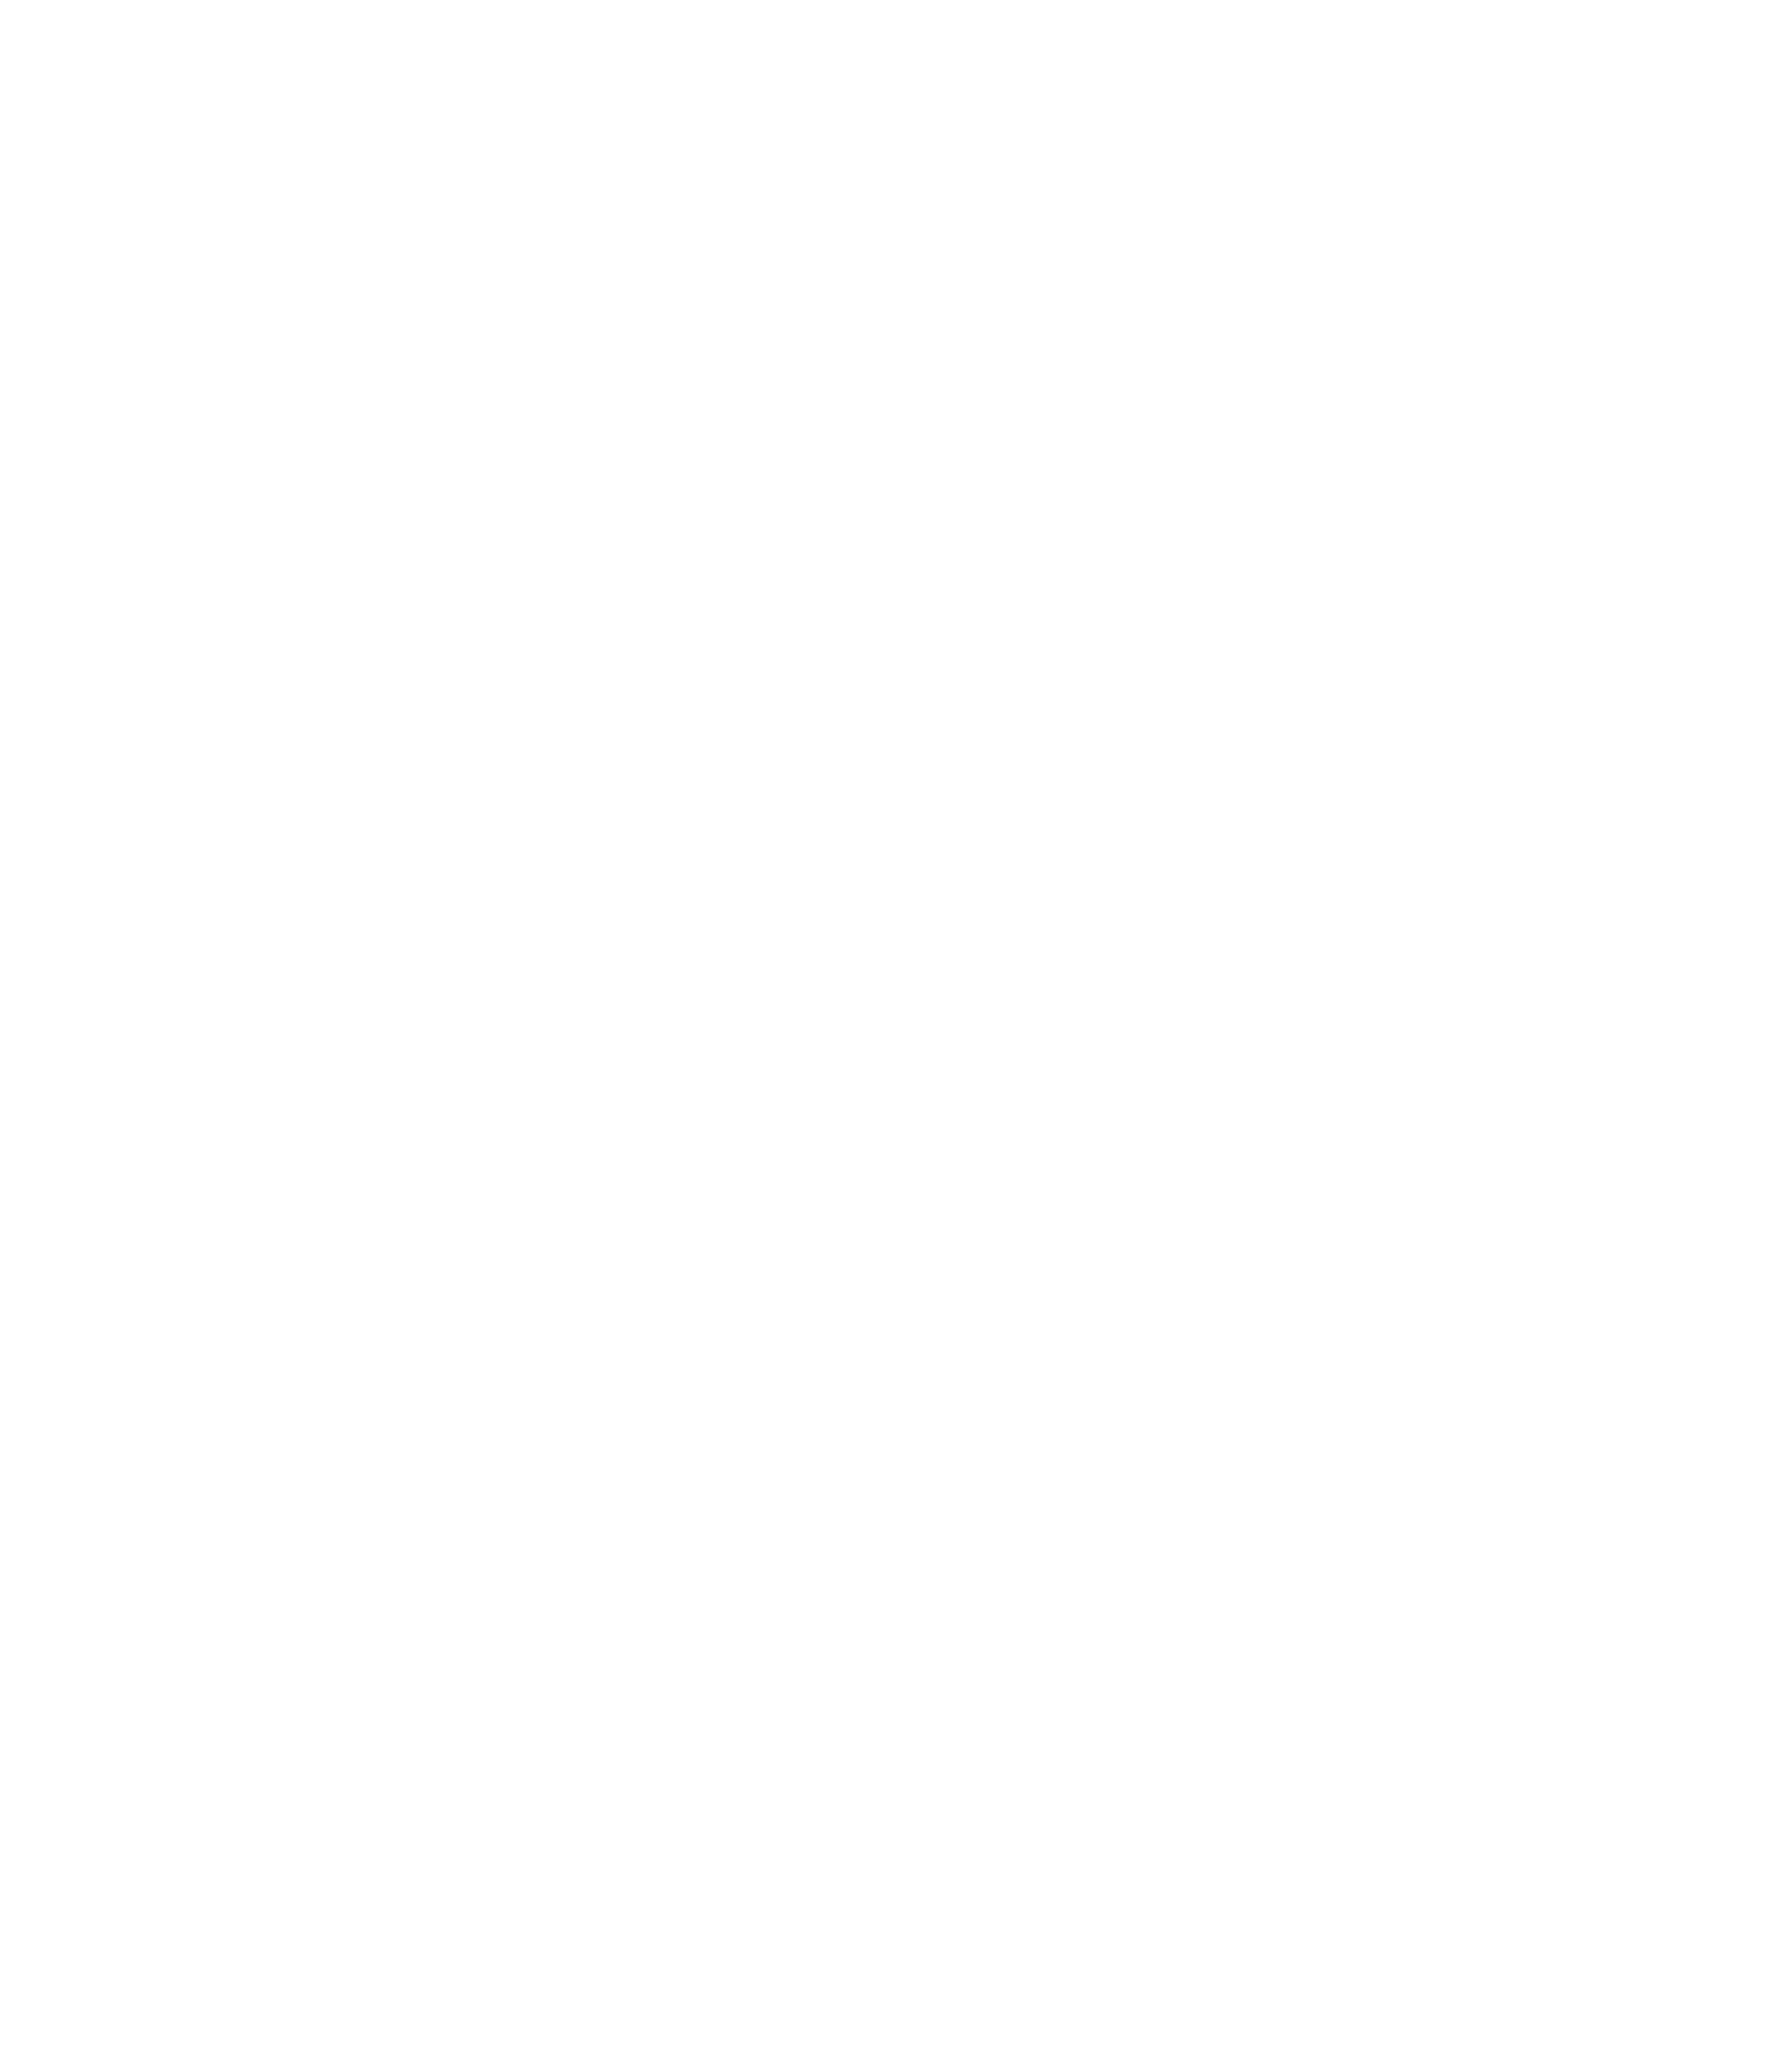

In [20]:
# Color both the metabolites and the rxns by group
# Of course some metabolites are reused, but that's ok
mol_group = {}
for i, molset in enumerate([glycolysis_kb_mols, ppp_kb_mols]):
    for mol in molset:
        mol_group[mol.label] = i
mol_group_scale = escher_map.Scale({0: ("#841f27", 20), 1: ("#355e3b", 20)})

rxn_group = {}
for i, rxnset in enumerate([glycolysis_kb_rxns, ppp_kb_rxns]):
    for rxn in rxnset:
        rxn_group[rxn.label] = i
rxn_group_scale = escher_map.Scale({0: ("#841f27", 15), 1: ("#355e3b", 15)})

# Build the glycolysis_ppp_ov pathway with diagram, and then display color-coded
glycolysis_ppp_ov = build_pathway('glycolysis_ppp_ov', 'Glycolysis + PPP + Overflow')
diag = escher_map.EscherMap(
    glycolysis_ppp_ov.diagram,
    width="12cm",
    metabolite_scale=mol_group_scale,
    reaction_scale=rxn_group_scale)
SVG(diag.draw(metabolite_data=mol_group, reaction_data=rxn_group))

21 of 21 pathway reactions covered.


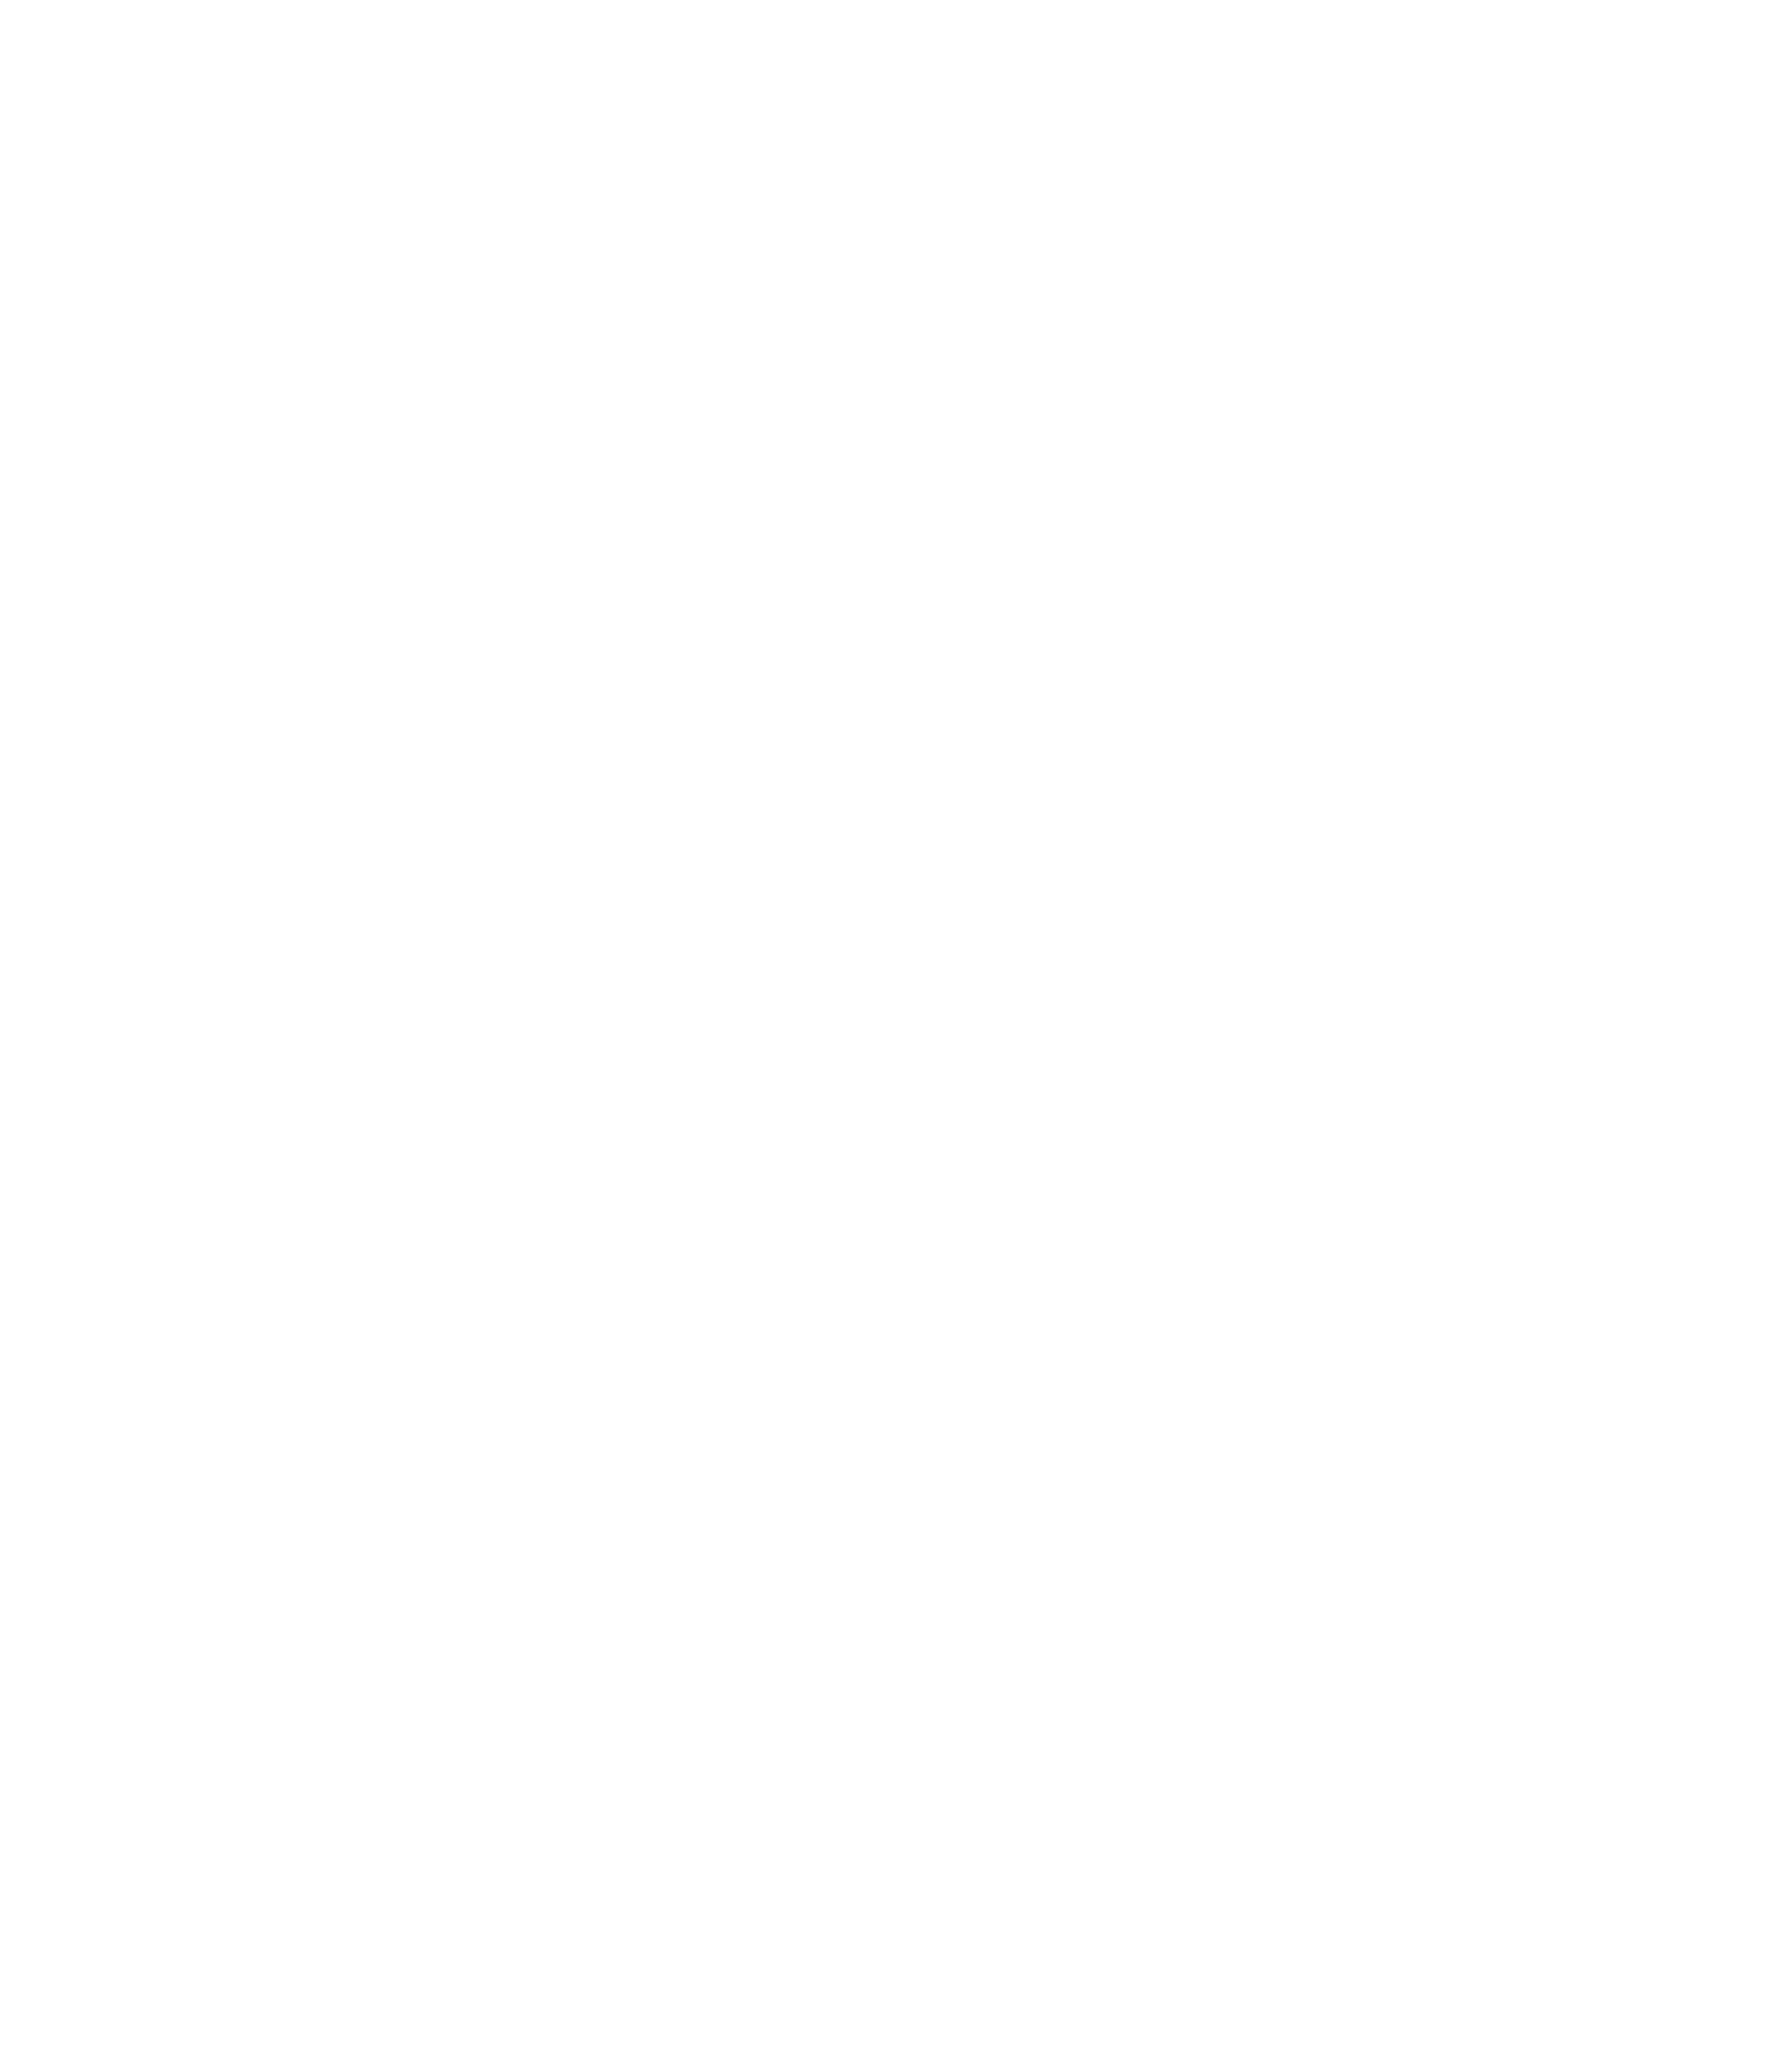

In [21]:
# Build the glycolysis_ppp_ov_simplified pathway with diagram, and then display color-coded
glycolysis_ppp_ov_simplified = build_pathway('glycolysis_ppp_ov_simplified', 'Glycolysis + PPP + Overflow (simplified)')
diag = escher_map.EscherMap(
    glycolysis_ppp_ov_simplified.diagram,
    width="12cm",
    metabolite_scale=mol_group_scale,
    reaction_scale=rxn_group_scale)
SVG(diag.draw(metabolite_data=mol_group, reaction_data=rxn_group))

## Save the pathways

In [22]:
KB.put(KB.pathways, glycolysis_ppp_ov)
KB.put(KB.pathways, glycolysis_ppp_ov_simplified)